## Setup

In [ ]:
%pip install swifter neuralprophet plotly kaleido statsmodels mariadb

In [ ]:
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import swifter
import dateutil
import datetime
import kaleido
import plotly
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import KPSSTest, auto_arima
from pmdarima.model_selection import train_test_split
import mariadb

from neuralprophet import NeuralProphet

## Data preparation

### Loading data

In [15]:
try:
    mydb = mariadb.connect(host="172.17.0.3", database = 'dados_tribunais',user="root", passwd="abc@123")
    query = "select * from processos where grau='JE' and tribunal='TJRN' and orgao_julgador = '4º JUIZADO ESPECIAL DA FAZENDA PÚBLICA';"
    df_tribunal = pd.read_sql(query,mydb)
    mydb.close() #close the connection
except Exception as e:
    mydb.close()
    print(str(e))

In [18]:
#df_tribunal = pd.read_csv('dados/processados/serie_temporal_ajuizamento-TJRN_G1_2018.csv', header='infer', sep=';')
df_tribunal.drop(columns=['numero_processo', 'tribunal', 'classe', 'ultima_atualizacao', 'codigo', 'municipio', 'grau', 'assuntos', 'movimentos'], inplace=True, errors='ignore')
print(df_tribunal.head(2))
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(dateutil.parser.parse)
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(datetime.datetime.date)

df_tribunal['data_sentenca'] = df_tribunal['data_sentenca'].swifter.apply(dateutil.parser.parse)
df_tribunal['data_sentenca'] = df_tribunal['data_sentenca'].swifter.apply(datetime.datetime.date)


  data_ajuizamento                          orgao_julgador data_sentenca  \
0       2019-01-02  4º JUIZADO ESPECIAL DA FAZENDA PÚBLICA    2019-01-02   
1       2019-01-02  4º JUIZADO ESPECIAL DA FAZENDA PÚBLICA    2019-03-18   

  tempo_ate_sentenca tempo_entre_1e2_mov tempo_entre_2e3_mov  \
0               None                   0                   0   
1               None                   0                   7   

  tempo_entre_3e4_mov  mais60d  
0                   0        0  
1                   0        0  


Pandas Apply:   0%|          | 0/17129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17129 [00:00<?, ?it/s]

In [20]:
dataframe = df_tribunal.groupby(['data_ajuizamento']).size()
df_tribunal = dataframe.to_frame(name='quantidade')
df_tribunal = df_tribunal.rename_axis('data_ajuizamento').reset_index()
print(df_tribunal)

     data_ajuizamento  quantidade
0          2018-01-03           3
1          2018-01-04           3
2          2018-01-08           1
3          2018-01-09           2
4          2018-01-10           1
...               ...         ...
2130       2024-05-02          14
2131       2024-05-03          14
2132       2024-05-04           4
2133       2024-05-06          14
2134       2024-05-07          15

[2135 rows x 2 columns]


In [ ]:
#df_tribunal['data_ajuizamento'] = pd.to_datetime(df_tribunal['data_ajuizamento'])

### Visualização dos dados

Série Temporal dos ajuizamentos ao longo do tempo

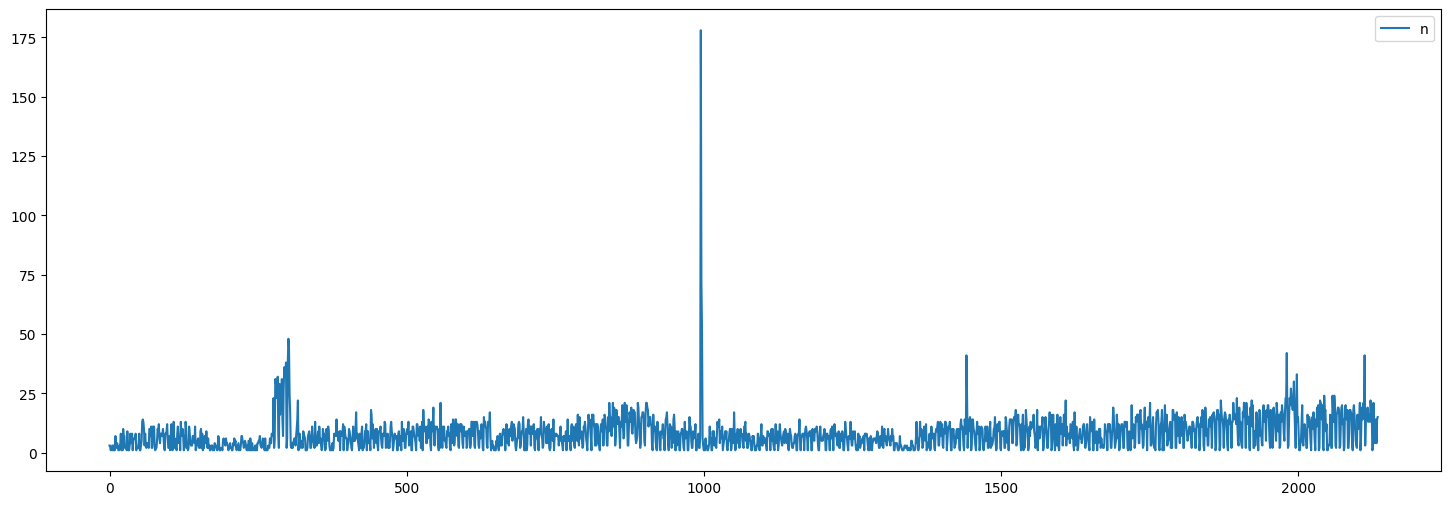

In [21]:
plt.figure(figsize=(18, 6))
plt.plot(df_tribunal['quantidade'], x=df_tribunal['data_ajuizamento'])
plt.legend('número de ajuizamentos')

## Análise estatística

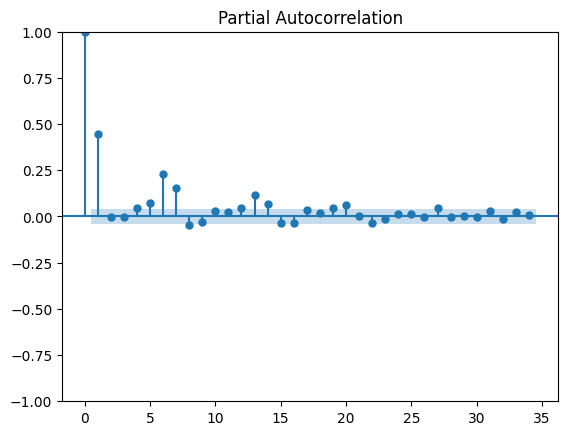

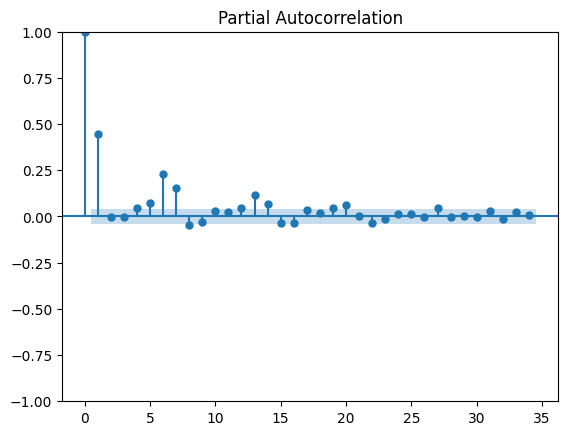

In [22]:
## PACF

df_pacf = df_tribunal
df_pacf.set_index('data_ajuizamento', inplace=True)
plot_pacf(df_pacf)

In [23]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_pacf.quantidade.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

if pval < 0.5:
    print('\n\nA série temporal é estacionária')
else:
    print('\n\nA série temporal não é estacionária')

ADF test statistic: -5.90010667051173
ADF p-values: 2.7910480228884825e-07
ADF number of lags used: 19
ADF number of observations: 2115
ADF critical values: {'1%': -3.433445628558137, '5%': -2.8629075228568746, '10%': -2.5674980038451007}
ADF best information criterion: 13601.888430140902


A série temporal é estacionária


# Métodos e modelos

## ARIMA e variantes

In [24]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


In [25]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=6, max_d=2,
            max_q=6, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=15, m=m,
            stepwise=True, trace=True)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]

In [26]:
test_size = 180
m = 30
horizon = 2
ts = df_pacf['quantidade']
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=12644.154, Time=12.87 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=13323.499, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=13150.422, Time=5.41 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=12857.922, Time=4.73 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=13321.499, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=12642.258, Time=8.30 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=12650.787, Time=0.51 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=12644.143, Time=182.10 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=12642.157, Time=8.50 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=12644.151, Time=28.66 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=12646.156, Time=33.99 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=12637.807, Time=10.97 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=12646.710, Time=0.38 sec
 ARIMA(1,1,2)(2,0,0)[30] intercept   : AIC=12639.793, Time=28.27 se

100%|██████████| 181/181 [04:30<00:00,  1.50s/it]


<Axes: xlabel='data_ajuizamento'>

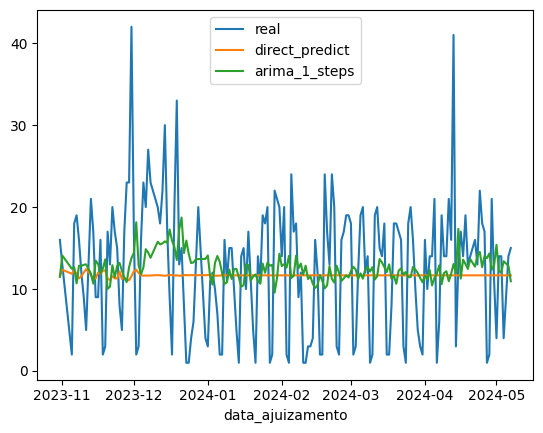

In [27]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()

In [28]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict', 'arima_1_steps']:
  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)
  
pd.DataFrame(metric_results)  

MSE      RMSE        MAPE       MAE        theil        ARV  \
0  63.692221  7.980741  165.297123  6.640405  1521.617274  60.240492   
1  65.935778  8.120085  181.702093  6.750376    27.370318  26.250892   

       POCID      model_name  
0  39.444444  direct_predict  
1  38.888889   arima_1_steps

## NeuralProphet

In [29]:
dados = pd.DataFrame()
df_tribunal.reset_index(inplace=True)
dados['ds'] = df_tribunal['data_ajuizamento']
dados['y'] = df_tribunal['quantidade']

In [30]:
#dados.to_csv('dados/neural_prophet_TJRN_G1_2018.csv', header=True, sep=';', index=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.583% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.data.processing._handle_missing_data) - Added 182 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 182 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 182 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.942% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.583% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.583% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 182 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 182 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 182 NaN values in column y were auto-imputed.


Predicting: 54it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


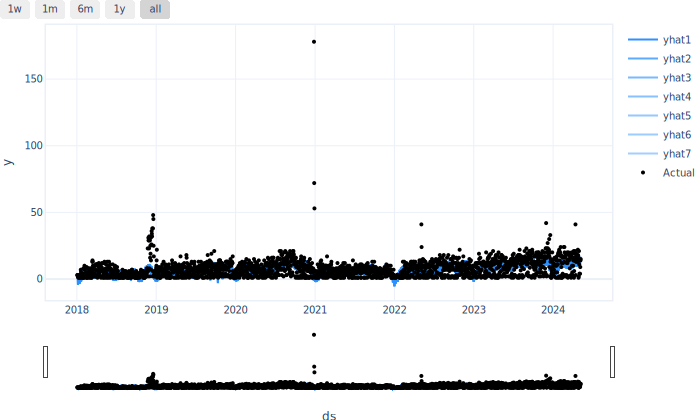

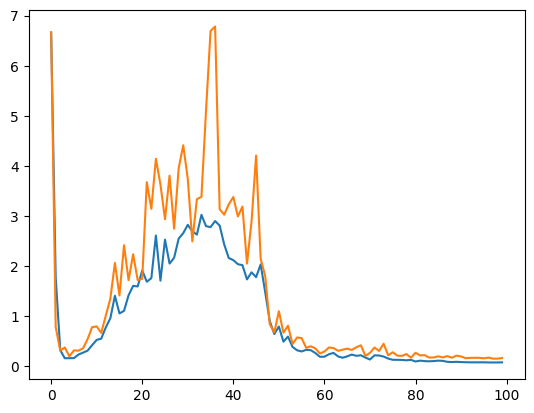

In [31]:
#dados = pd.read_csv('dados/neural_prophet_TJRN_G1_2018.csv', header='infer', sep=';')
#dados = dados[dados.y < 6000]
m = NeuralProphet(n_lags=1, n_forecasts=7, ar_layers=(16, 64))
m = m.add_country_holidays("BR")
m.set_plotting_backend("plotly-static")
df_train, df_val = m.split_df(dados, valid_p=0.25)
metrics = m.fit(df_train, validation_df=df_val, freq='D', progress="plot")
forecast = m.predict(dados)
m.plot(forecast)

In [32]:
m.plot_components(forecast)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_model_parameters_plotly.py:377: RuntimeWarning:

invalid value encountered in divide




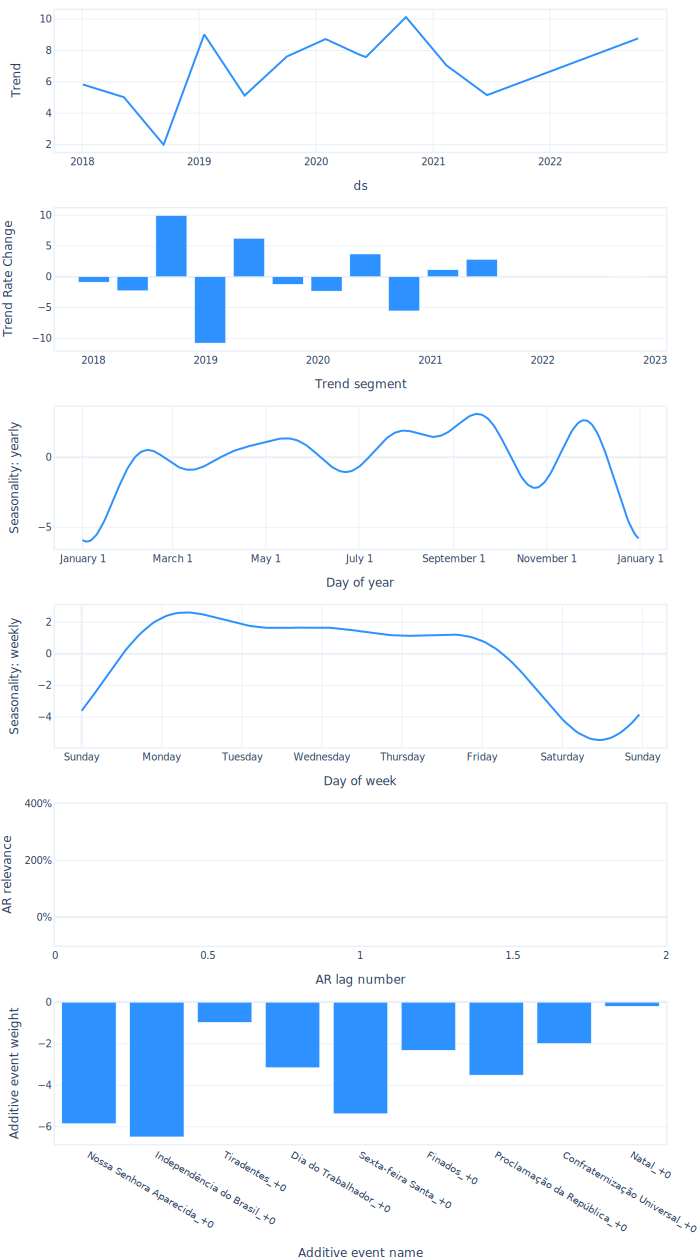

In [33]:
m.plot_parameters()

In [34]:
print(metrics.tail(5))

     MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
95  3.901221  5.082806  0.160926          0.0     95  3.001951  5.396950   
96  4.158412  5.302041  0.175579          0.0     96  2.938375  5.238441   
97  3.786187  4.980900  0.154748          0.0     97  2.921047  5.332827   
98  3.798446  4.997334  0.154987          0.0     98  2.924012  5.340919   
99  3.952549  5.124429  0.165794          0.0     99  2.982162  5.282360   

        Loss  RegLoss  
95  0.081726      0.0  
96  0.079136      0.0  
97  0.078291      0.0  
98  0.078512      0.0  
99  0.080950      0.0  


In [35]:
print(dados['y'].describe())

count    2135.000000
mean        8.022951
std         7.133546
min         1.000000
25%         3.000000
50%         7.000000
75%        11.000000
max       178.000000
Name: y, dtype: float64


## Prophet

In [36]:
recesso_judiciario = pd.DataFrame({
  'holiday': 'recesso_judiciario',
  'ds': pd.to_datetime(['2018-12-19', '2019-12-19', 
                        '2020-12-19', '2021-12-19',
                        '2022-12-19', '2023-12-19',
                        '2024-12-19', '2025-12-19']),
  'lower_window': 0,
  'upper_window': 18,
})

In [37]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

m = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01,interval_width=0.99, holidays=recesso_judiciario)
m.add_country_holidays(country_name='BR')
m.fit(dados)
df_cv = cross_validation(m, initial='1080 days', period='60 days', horizon = '180 days', parallel="processes")

df_p = performance_metrics(df_cv)
df_p.head(5)

22:03:27 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] done processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:29 - cmdstanpy - INFO - Chain [1] done processing
22:03:30 - cmdstanpy - INFO - Chain [1] done processing
22:03:30 - cmdstanpy - INFO - Chain [1] done processing
22:03:30 - cmdstanpy - INFO - Chain

horizon        mse      rmse       mae      mape     mdape     smape  \
0 18 days  14.054443  3.748926  3.047055  0.703557  0.340877  0.510791   
1 19 days  15.172393  3.895176  3.156631  0.728748  0.345522  0.514920   
2 20 days  15.404003  3.924793  3.186962  0.728442  0.350784  0.515359   
3 21 days  17.840637  4.223818  3.271286  0.747665  0.351964  0.526119   
4 22 days  18.270896  4.274447  3.275255  0.757419  0.347800  0.531931   

   coverage  
0  1.000000  
1  1.000000  
2  1.000000  
3  0.996656  
4  0.996656

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1402802/481289654.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




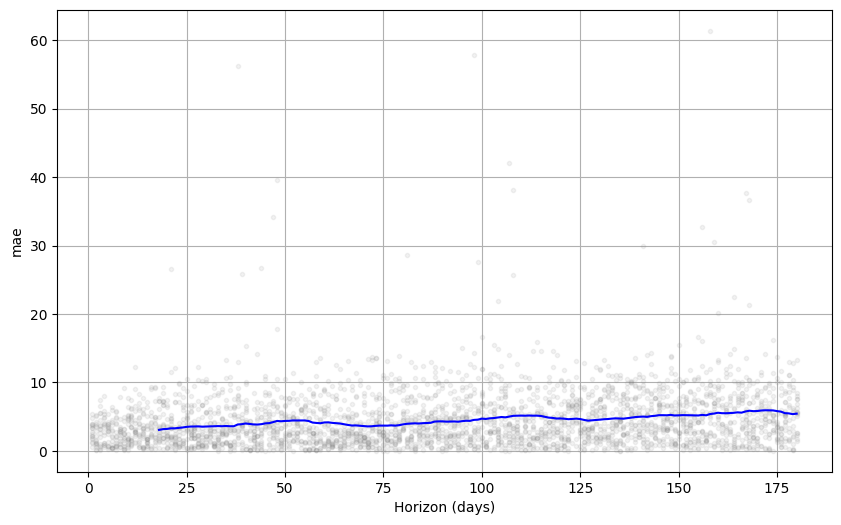

In [38]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig.show()